# First Score Model

Paper: https://arxiv.org/abs/1907.05600

In [8]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn


from torch.autograd import grad
from torch.autograd.functional import jacobian

Using torch 1.13.1


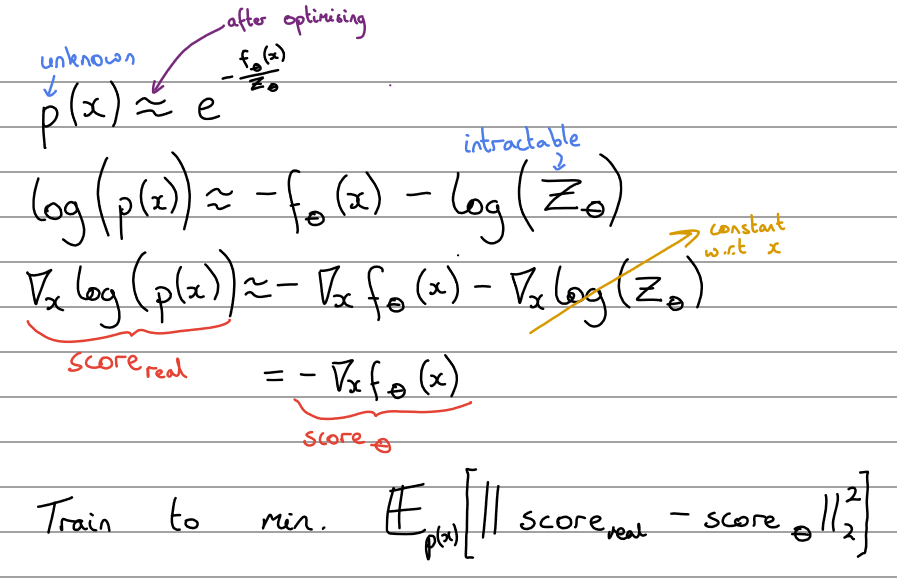

In [9]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),  
            nn.Sigmoid(),
            nn.Linear(64, 128),  
            nn.Sigmoid(),
            nn.Linear(128, output_dim)
        )

    def forward(self, X):
        score = jacobian(self.layers, X)

        return score
    

In [10]:
def efficient_loss_function(score, x):
    """
    Avoid using the gradient of an energy-based model for computational efficiency.

    See paper...
    """

    return np.trace(grad(score, x)) + 0.5 * (np.linalg.norm(score, 2) ** 2)

In [11]:
class Sampler:
    def __init__(self, epsilon, num_samples = 100, timesteps = 100, device = 'cuda') -> None:
        self.eps = epsilon 
        self.device = device
        self.T = timesteps
        self.samples = num_samples

    def sample_step(self, model, x_t):

        # Sample from standard gaussian
        z = torch.randn_like(x_t, device = self.device)

        # Langevin sample step
        return x_t + ((self.eps / 2) * model(x_t)) + (torch.sqrt(self.eps, device = self.device) * z)
    
    def sampling_loop(self, model):
        # Sample x_T from the standard Gaussian distribution as a scalar tensor
        x_t = torch.randn(size=(self.samples, 2), device=self.device)

        for t in range(self.T):
            x_t = self.sample_step(model, x_t)

        return x_t

In [12]:
def train_step(model, X, optimiser, loss_fn, current_epoch):
    total_loss = 0.0

    with tqdm(X, dynamic_ncols=True) as tqdm_obj:
        tqdm_obj.set_description(f"Epoch [{current_epoch}]")
            
        for x in tqdm_obj: 

            # 1. Forward pass
            score = model(x)

            # 2. Calc loss
            loss = loss_fn(score, x)

            # 3. Optimizer zero-grad
            optimiser.zero_grad()

            # 4. Backpropagation
            loss.backward()

            # 5. Update -- gradient ascent
            optimiser.step() 

            total_loss += loss.item()

            tqdm_obj.set_postfix_str(s=f"Loss: {total_loss:.4f}")

        avg_loss = total_loss / len(X)

        # Update the progress bar with the average loss after the loop
        tqdm_obj.set_postfix_str(s=f"Epoch Loss: {avg_loss:.4f}")

    return avg_loss

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

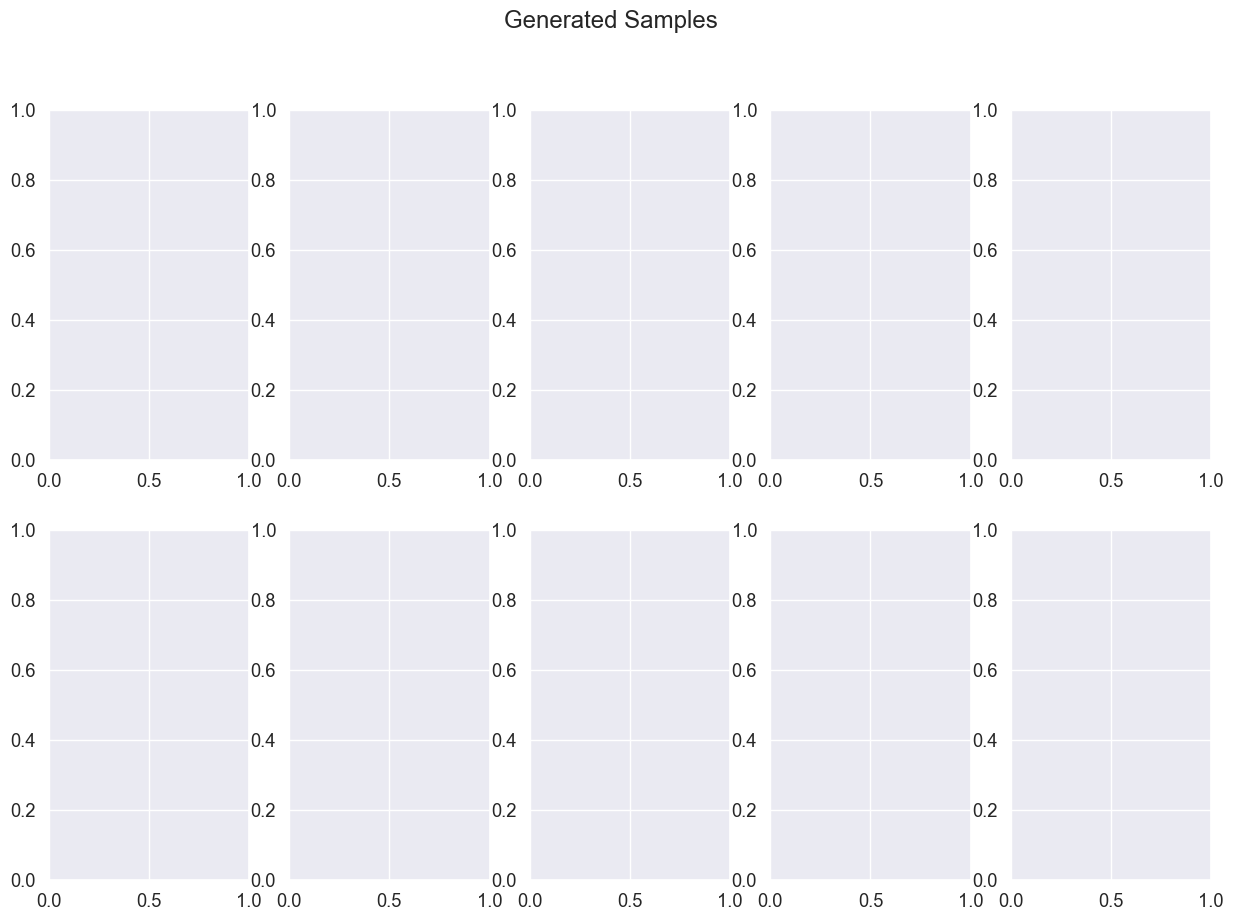

In [13]:
# Hyperparams
EPOCHS = 100
TIMESTEPS = 100
SAMPLES = 100
EPSILON = 0.1
LR = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the moons dataset
X, _ = make_moons(n_samples=100, noise=0.05, random_state=42)
X = torch.tensor(X, device = device).float()

sampler = Sampler(epsilon=EPSILON, 
                  num_samples = SAMPLES, 
                  timesteps = TIMESTEPS, 
                  device = device)

net = ScoreNet(input_dim = X.shape[1], 
               output_dim = X.shape[1]).to(device)

optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = efficient_loss_function

# Calculate the number of rows and columns for subplots
sample_every = 10 # Plot every 10th timestep
num_plots = (EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

for epoch in range(1, EPOCHS+1):
    avg_loss = train_step(model = net, 
                          X = X, 
                          optimiser = optimiser, 
                          loss_fn = loss_function, 
                          current_epoch = epoch)
    
    if (epoch % sample_every == 0 or epoch == EPOCHS) and (epoch > 0):
                with torch.no_grad():
                        
                        # Draw samples using updates score net
                        xT = sampler.sampling_loop(net)
                        
                        plot_num = (epoch // sample_every) - 1
                        row = plot_num // num_cols
                        col = (plot_num % num_cols)

                        # Plot x0 on the specified subplot
                        sns.scatterplot(x=xT[:, 0].cpu().numpy(), y=xT[:, 1].cpu().numpy(),
                        color='red', marker='o', ax=axs[row, col])

                        axs[row, col].set_title(f'Epoch: {epoch}')
                
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()